In [1]:
import json
import torch
import requests
from PIL import Image
from together import Together
from io import BytesIO
from transformers import CLIPProcessor, CLIPModel
from dotenv import load_dotenv

# .env 파일 로드
load_dotenv()

# Together API 클라이언트 설정
client = Together(api_key="")  # API 키를 입력하세요

# CLIP 모델과 프로세서 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 실행 흐름
keywords_file = "keyword.json"
embedding_file = "keyword_embeddings.json"
rag_dataset_file = "QwQ_rag_dataset.json"
username = "KimEunOh"
repo = "image"
branch = "main"
folder_path = "final_test"

c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\lmm-FvM8fsL0-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\lmm-FvM8fsL0-py3.11\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\lmm-FvM8fsL0-py3.11\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will b

In [2]:
import pandas as pd

# CSV 파일 로드
df = pd.read_csv("Test_dataset_results_final_11B.csv")

# 모델_Label이 0인 데이터 필터링
filtered_data = df[df["모델_Label"] == 0]["FileName"].tolist()
labels = df[df["모델_Label"] == 0]["Label"].tolist()

# 결과 출력
print(filtered_data)

['1019053_1979-02-28_2006.jpg', '1027753_1885-01-30_1943.jpg', '1083353_1975-09-23_2006.jpg', '1181653_1981-07-05_2014.jpg', '1297053_1943-02-07_2009.jpg', '1394553_1975-01-08_2007.jpg', '1399753_1888-05-11_1942.jpg', '140453_1914-01-15_1975.jpg', '1429653_1971-01-31_2006.jpg', '1489953_1956-04-08_1984.jpg', '1491853_1985-11-19_2011.jpg', '1574853_1962-11-03_1984.jpg', '1588053_1922-12-03_1997.jpg', '183753_1917-01-05_1947.jpg', '1920453_1971-02-25_2009.jpg', '1937253_1975-04-10_2015.jpg', '202553_1952-08-04_2011.jpg', '2132353_1943-09-08_2007.jpg', '2142453_1925-01-29_1951.jpg', '2161453_1950-02-03_1973.jpg', '2215153_1939-08-27_1975.jpg', '22753_1895-07-12_1940.jpg', '2304453_1969-08-15_2010.jpg', '231653_1902-06-19_1947.jpg', '2380653_1977-03-20_2007.jpg', '262253_1923-07-15_1970.jpg', '262953_1950-05-03_1970.jpg', '2778253_1946-08-09_1972.jpg', '2871353_1972-10-04_2011.jpg', '3002053_1971-04-16_2011.jpg', '303853_1936-05-14_1985.jpg', '3046653_1979-02-20_2007.jpg', '3083253_1962-07

In [3]:
# 1. 키워드 임베딩 로드
def load_keyword_embeddings(embedding_file):
    with open(embedding_file, "r", encoding="utf-8") as infile:
        data = json.load(infile)
        # 임베딩이 1차원 형태 [512] 인지 검증 및 변환
        for entry in data:
            emb = torch.tensor(entry["embedding"], dtype=torch.float)
            if emb.dim() > 1:
                emb = emb.view(-1)
            entry["embedding"] = emb.tolist()
        return data


# 2. GitHub의 목록으로부터 이미지 URL 리스트 전달받음
def get_github_image_urls(username, repo, branch, folder_path, file_names=None):
    api_url = f"https://api.github.com/repos/{username}/{repo}/contents/{folder_path}?ref={branch}"
    try:
        response = requests.get(api_url)
        response.raise_for_status()
        files = response.json()
        image_urls = [
            f"https://raw.githubusercontent.com/{username}/{repo}/{branch}/{folder_path}/{file['name']}"
            for file in files
            if file.get("name", "").lower().endswith((".jpg", ".jpeg", ".png"))
            and (file_names is None or file["name"] in file_names)
        ]
        return image_urls
    except Exception as e:
        print(f"Error fetching image URLs from GitHub: {e}")
        return []


# 3. 이미지 임베딩을 수행하여, 기존에 저장된 텍스트 임베딩 값과 유사도 계산
def embed_image_and_calculate_similarity(image_urls, keyword_embeddings):
    results = []
    for image_url in image_urls:
        try:
            response = requests.get(image_url)
            response.raise_for_status()
            image = Image.open(BytesIO(response.content)).convert("RGB")

            inputs = clip_processor(images=image, return_tensors="pt").to(device)
            with torch.no_grad():
                image_embedding = (
                    clip_model.get_image_features(**inputs).cpu().squeeze()
                )  # [512]

            similarities = []
            for entry in keyword_embeddings:
                keyword_emb = torch.tensor(
                    entry["embedding"], dtype=torch.float
                )  # [512]
                # 단일 벡터간 유사도 계산 시 dim=0으로 설정
                similarity = torch.nn.functional.cosine_similarity(
                    keyword_emb, image_embedding, dim=0
                ).item()
                similarities.append(
                    {"keywords": entry["keywords"], "similarity": similarity}
                )

            # 가장 높은 유사도 키워드 추출
            most_relevant = max(similarities, key=lambda x: x["similarity"])
            results.append({"image_url": image_url, "relevant_keywords": most_relevant})
        except Exception as e:
            print(f"Error processing image {image_url}: {e}")
            continue
    return results


# 4. 추출된 키워드들을 바탕으로 프롬프트 생성
def generate_prompts(results):
    prompts = []
    for result in results:
        image_url = result["image_url"]
        relevant_keywords = [result["relevant_keywords"]["keywords"]]
        prompt = f"""
            Analyze the image at the following URL: {image_url}.  
            Using the following keywords as a checklist: {', '.join(relevant_keywords)}.  

            ### Instructions:  
            1. For each keyword, carefully examine the image and objectively verify whether 
            the described clue is present. Avoid making assumptions and clearly state if no issues are observed.  
            2. Maintain neutrality in your evaluation and do not assume the presence of
              manipulation unless there is strong and consistent evidence across multiple clues.  
            3. If anomalies are observed, provide a factual description without inferring
              intent or confirming manipulation prematurely.  
            4. If no clear anomalies are found, highlight natural variations or explain 
            why observed features may align with expected real-world variations.  
            5. There is a high probability that the provided list of image URLs are REAL;
              only categorize them as FAKE if there is a high probability.
            
            ### Example Response :
            {{
                "Result": "real",
                "Observations": [
                    {{
                        "keyword": "Mismatched shadows",
                        "observation": "Shadows appear consistent with the lighting source."
                    }},
                    {{
                        "keyword": "Unnatural facial features",
                        "observation": "Slight asymmetry observed, but within the range of natural human variation."
                    }},
                    {{
                        "keyword": "Smooth skin texture",
                        "observation": "Minor smoothness noted, but could be due to lighting or image compression."
                    }}
                ],
                "Assessment": "There is no strong evidence of manipulation in this image.",
                "Explanation": "While slight irregularities were noted, these can be attributed to natural variations or external factors like lighting and resolution. No significant anomalies were found to indicate deepfake manipulation."
            }}
            """
        prompts.append({"image_url": image_url, "prompt": prompt.strip()})
    return prompts


# 4. 이미지 URL과 프롬프트를 쌍으로 한 rag_dataset.json 파일 생성
def save_rag_dataset(prompts, output_file):
    with open(output_file, "w", encoding="utf-8") as outfile:
        json.dump(prompts, outfile, ensure_ascii=False, indent=4)

In [4]:
# 키워드 임베딩 로드
keyword_embeddings = load_keyword_embeddings(embedding_file)


# 이미지 리스트 생성
image_urls = get_github_image_urls(
    username, repo, branch, folder_path, file_names=filtered_data
)

# 이미지 임베딩 및 유사도 계산
results = embed_image_and_calculate_similarity(image_urls, keyword_embeddings)

In [5]:
# 프롬프트 생성
prompts = generate_prompts(results)
save_rag_dataset(prompts, rag_dataset_file)

print(f"RAG dataset saved to {rag_dataset_file}")

RAG dataset saved to llama_rag_dataset.json


In [6]:
system_prompt = """
Analyze the provided image to determine if it is "fake" or "real" based on the criteria listed. Ensure a balanced and objective evaluation without making assumptions or bias toward either outcome.

### Response Format:  
{
    
    "Observations": [
        {
            "keyword": "Keyword being analyzed",
            "observation": "Specific observation related to the keyword."
        },
        {
            "keyword": "Another keyword",
            "observation": "Another observation."
        }
    ],
    "Assessment": "A concise summary of the analysis, stating whether the image is more likely real or fake based on observed evidence.",
    "Explanation": "Provide a reasoned explanation of the decision, citing specific observations and addressing any ambiguity or natural variations."
    "Result": "fake" or "real"
}
"""

In [7]:
import re
import json
from typing import List
from pydantic import ValidationError
from pydantic import BaseModel, Field, ValidationError
from langchain_together import Together


class Observation(BaseModel):
    keyword: str = Field(..., description="Keyword being analyzed.")
    observation: str = Field(
        ..., description="Specific observation related to the keyword."
    )


class PredictionResponse(BaseModel):
    observations: List[Observation] = Field(
        ...,
        alias="Observations",
        description="A list of keywords with corresponding observations.",
    )
    assessment: str = Field(
        ...,
        alias="Assessment",
        description="A concise summary of the analysis, stating whether the image is more likely real or fake based on observed evidence.",
    )
    explanation: str = Field(
        ...,
        alias="Explanation",
        description="Provide a reasoned explanation of the decision, citing specific observations and addressing any ambiguity or natural variations.",
    )
    result: str = Field(
        ...,
        alias="Result",
        description="The prediction result, either 'fake' or 'real'.",
    )

    class Config:
        allow_population_by_field_name = True
        schema_extra = {
            "example": {
                "Observations": [
                    {
                        "keyword": "Mismatched shadows",
                        "observation": "Shadows appear consistent with the lighting source.",
                    },
                    {
                        "keyword": "Unnatural facial features",
                        "observation": "Slight asymmetry observed, but within the range of natural human variation.",
                    },
                    {
                        "keyword": "Smooth skin texture",
                        "observation": "Minor smoothness noted, but could be due to lighting or image compression.",
                    },
                ],
                "Assessment": "There is no strong evidence of manipulation in this image.",
                "Explanation": "While slight irregularities were noted, these can be attributed to natural variations or external factors like lighting and resolution. No significant anomalies were found to indicate deepfake manipulation.",
                "Result": "real",
            }
        }


# JSON 추출 함수
def extract_json(response_text):
    """
    Cleans and fixes invalid JSON responses.
    Removes invalid control characters and fixes multi-line strings in the reason field.
    """
    try:
        # JSON만 추출
        json_match = re.search(r"\{[\s\S]*\}", response_text)
        if json_match:
            json_text = json_match.group()

            # 잘못된 따옴표 수정
            json_text = json_text.replace(""", '"').replace(""", '"')

            # reason 필드의 개행문자와 불필요한 기호 제거
            json_text = re.sub(r"- ", "", json_text)  # 불필요한 '-' 제거
            json_text = re.sub(r"\n\s*", " ", json_text)  # 개행 및 들여쓰기 제거

            # JSON 디코딩
            return json.loads(json_text)
    except json.JSONDecodeError as e:
        print(f"JSON decoding error: {e}")
    return None

c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\lmm-FvM8fsL0-py3.11\Lib\site-packages\pydantic\_internal\_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [10]:
# 결과를 저장할 데이터프레임 생성
results = []

# RAG 데이터셋 로드
with open(rag_dataset_file, "r", encoding="utf-8") as infile:
    rag_data = json.load(infile)

# 각 이미지 처리
for index, row in enumerate(rag_data):  # enumerate로 인덱스와 함께 가져오기
    image_url = row["image_url"]
    prompt = row["prompt"]

    print(f"\nProcessing image: {image_url}")

    # API 요청
    try:
        response_generator = client.chat.completions.create(
            model="meta-llama/Llama-3.2-11B-Vision-Instruct-Turbo",
            messages=[
                {"role": "system", "content": system_prompt},
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {"type": "image_url", "image_url": {"url": image_url}},
                    ],
                },
            ],
            temperature=0,
            top_p=0.7,
            top_k=60,
            repetition_penalty=1,
            stop=["<|eot_id|>", "<|eom_id|>"],
            stream=True,  # 스트리밍 활성화
        )

        response_text = ""
        for token in response_generator:
            if hasattr(token, "choices") and token.choices:
                response_text += token.choices[0].delta.content

    except Exception as e:
        print(f"Error processing image {image_url}: {e}")
        continue

    # JSON 응답 추출 및 검증
    response_data = extract_json(response_text)
    if response_data:
        try:
            prediction = PredictionResponse(**response_data)
            # Observations 처리
            observations = [
                f"Keyword: {obs.keyword}, Observation: {obs.observation}"
                for obs in prediction.observations
            ]

            # Assessment, Explanation, Result 추출
            assessment = prediction.assessment
            explanation = prediction.explanation
            model_result = prediction.result.lower()  # 결과를 소문자로 처리
        except ValidationError as e:
            print(f"Validation error for {image_url}: {e}")
            model_result = "-1"
            explanation = "Validation error occurred."
            assessment = "Validation error"
            observations = []
    else:
        print(f"Failed to extract valid JSON for {image_url}")
        print(f"Response text: {response_text}")  # 응답 내용을 출력
        model_result = "-1"
        continue

    # 결과 변환
    if model_result == "fake":
        model_label = 1
    elif model_result == "real":
        model_label = 0
    else:
        model_label = -1

    results.append(
        {
            "FileName": image_url.split("/")[-1],  # 파일 이름 추출
            "url": image_url,
            "Observations": observations,  # 키워드 및 관찰 내용
            "Assessment": assessment,
            "Explanation": explanation,
            "모델_Label": model_label,
        }
    )


Processing image: https://raw.githubusercontent.com/KimEunOh/image/main/final_test/002263.jpg
Failed to extract valid JSON for https://raw.githubusercontent.com/KimEunOh/image/main/final_test/002263.jpg
Response text: **Observations:**

*   **Misaligned eyes:** The eyes appear to be aligned, with no noticeable misalignment.
*   **Unnatural facial tilt:** The facial tilt appears natural, with no indication of manipulation.
*   **Distorted nose and mouth:** The nose and mouth appear normal, with no distortion observed.
*   **Odd eyebrow and ear positioning:** The eyebrows and ears appear in their typical positions, with no unusual placement noted.
*   **Exaggerated smile:** The smile appears natural, with no exaggeration observed.
*   **Unclear teeth representation:** The teeth are clearly visible, with no ambiguity in their representation.
*   **Unusually smooth skin texture:** The skin texture appears normal, with no unusual smoothness observed.
*   **Skin tone mismatch between face a

In [28]:
import os

# 리스트를 DataFrame으로 변환
results_df = pd.DataFrame(results)

# 기존 결과 병합
output_file = "rag_results_11B.csv"
if os.path.exists(output_file) and os.stat(output_file).st_size > 0:
    try:
        existing_results = pd.read_csv(output_file)
    except pd.errors.EmptyDataError:
        existing_results = pd.DataFrame()
else:
    existing_results = pd.DataFrame()

results_df = pd.concat(
    [existing_results, results_df], ignore_index=True
).drop_duplicates(subset=["FileName"])

# 결과 저장
results_df.to_csv(output_file, index=False, encoding="utf-8-sig")
print(f"\nProcessed results saved to {output_file}")


Processed results saved to rag_results_90B.csv


In [30]:
import pandas as pd

# 저장된 결과 CSV와 참조 CSV 로드
results_csv = pd.read_csv("rag_results_11B.csv")  # 기존 결과 파일
reference_csv = pd.read_csv("Test_dataset_results_final_11B.csv")  # 참조 파일

# URL을 기준으로 레이블 매칭
merged_results = results_csv.merge(reference_csv, on="url", how="left")

# 매칭되지 않은 경우를 확인하고 처리
if merged_results["Label"].isnull().any():
    print("Some URLs in 'rag_results_11B.csv' do not have a matching label.")
    merged_results["Label"] = merged_results["Label"].fillna("Unknown")

# 병합된 결과 저장
merged_results.to_csv("merged_results_with_labels.csv", index=False)

print("Merged results saved to 'merged_results_with_labels.csv'")

Merged results saved to 'merged_results_with_labels.csv'



Model Accuracy: 76.71%

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        57
           1       0.44      0.25      0.32        16

    accuracy                           0.77        73
   macro avg       0.63      0.58      0.59        73
weighted avg       0.73      0.77      0.74        73


Confusion Matrix:
[[52  5]
 [12  4]]


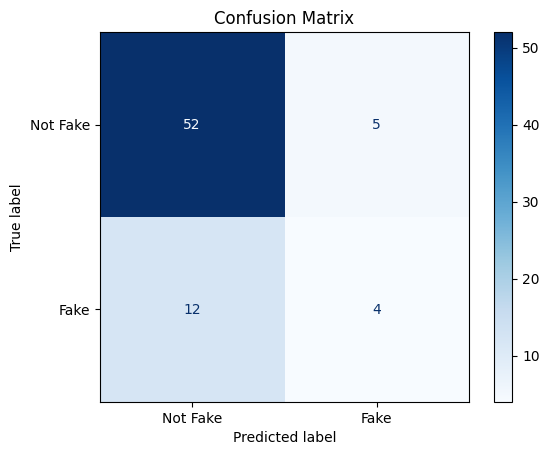

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

merged_df = pd.read_csv("merged_results_with_labels.csv")

# 정확도 계산
valid_results = merged_df[merged_df["모델_Label_x"] != -1]  # 유효한 결과만 필터링
accuracy = accuracy_score(valid_results["Label"], valid_results["모델_Label_x"])
print(f"\nModel Accuracy: {accuracy:.2%}")

# 추가적인 정밀도, 재현율, F1 점수 계산
print("\nClassification Report:")
print(classification_report(valid_results["Label"], valid_results["모델_Label_x"]))

# 혼동 행렬 계산
cm = confusion_matrix(valid_results["Label"], valid_results["모델_Label_x"])
print("\nConfusion Matrix:")
print(cm)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fake", "Fake"])
disp.plot(cmap="Blues")  # 색상 지도 설정
plt.title("Confusion Matrix")
plt.show()